In [ ]:
%matplotlib inline
import time
import random
from random import shuffle
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import itertools
import logging

import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import transforms, datasets, models
from torchvision.datasets import CIFAR10

from scipy.stats import entropy, ks_2samp
from scipy.special import kl_div
from sklearn import metrics
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import label_binarize

# from torch.utils.tensorboard import SummaryWriter
# %load_ext tensorboard

import traceback
import copy

In [2]:
logname = 'logs/decentralized_distil'
logging.basicConfig(filename=logname,
                            filemode='a',
                            format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                            datefmt='%H:%M:%S',
                            level=logging.DEBUG)

logging.info("Running Decentralized Learning test")

logger = logging.getLogger('Decentralized_log')

In [3]:
np.random.seed(0)
torch.manual_seed(3)

In [4]:
# Standard transformations for improving CIFAR10. 

# Transformations A
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Transformations B
RC   = transforms.RandomCrop(32, padding=4)
RHF  = transforms.RandomHorizontalFlip()
RVF  = transforms.RandomVerticalFlip()
NRM  = transforms.Normalize([0.5], [0.5])
TT   = transforms.ToTensor()
TPIL = transforms.ToPILImage()

# Transforms object for trainset with augmentation
transform_with_aug = transforms.Compose([TPIL, RC, RHF, TT, NRM])
# Transforms object for testset with NO augmentation
transform_no_aug   = transforms.Compose([TPIL, TT, NRM])

# Downloading/Louding CIFAR10 data
trainset = torchvision.datasets.FashionMNIST(root='../../../data/fmnist', train=True,
                                        download=True, transform=transform_with_aug)

testset = torchvision.datasets.FashionMNIST(root='../../../data/fmnist', train=False,
                                       download=True, transform=transform_no_aug)


classDict = {'T-shirt/top':0, 'Trouser':1, 'Pullover':2, 'Dress':3, 'Coat':4, 'Sandal':5, 'Shirt':6, 'Sneaker':7, 'Bag':8, 'Ankle boot':9}

# Separating trainset/testset data/label
x_train  = trainset.data
x_test   = testset.data
y_train  = trainset.targets
y_test   = testset.targets

# Define a function to separate CIFAR classes by class index

def get_class_i(x, y, i):
    """
    x: trainset.train_data or testset.test_data
    y: trainset.train_labels or testset.test_labels
    i: class label, a number between 0 to 9
    return: x_i
    """
    # Convert to a numpy array
    y = np.array(y)
    # Locate position of labels that equal to i
    pos_i = np.argwhere(y == i)
    # Convert the result into a 1-D list
    pos_i = list(pos_i[:,0])
    # Collect all data that match the desired label
    x_i = [x[j] for j in pos_i]
    
    return x_i

class DatasetMaker(Dataset):
    def __init__(self, datasets, transformFunc = transform_no_aug):
        """
        datasets: a list of get_class_i outputs, i.e. a list of list of images for selected classes
        """
        self.datasets = datasets
        self.lengths  = [len(d) for d in self.datasets]
        self.transformFunc = transformFunc
    def __getitem__(self, i):
        class_label, index_wrt_class = self.index_of_which_bin(self.lengths, i)
        img = self.datasets[class_label][index_wrt_class]
        img = self.transformFunc(img)
        return img, class_label

    def __len__(self):
        return sum(self.lengths)
    
    def index_of_which_bin(self, bin_sizes, absolute_index, verbose=False):
        """
        Given the absolute index, returns which bin it falls in and which element of that bin it corresponds to.
        """
        # Which class/bin does i fall into?
        accum = np.add.accumulate(bin_sizes)
        if verbose:
            print("accum =", accum)
        bin_index  = len(np.argwhere(accum <= absolute_index))
        if verbose:
            print("class_label =", bin_index)
        # Which element of the fallent class/bin does i correspond to?
        index_wrt_class = absolute_index - np.insert(accum, 0, 0)[bin_index]
        if verbose:
            print("index_wrt_class =", index_wrt_class)

        return bin_index, index_wrt_class

==> Preparing data..


In [5]:
# If we are saving a fraction
frac = int(len(x_train) * 0.05)
x_reserve = x_train[:frac]
y_reserve = y_train[:frac]
x_train = x_train[frac:]
y_train = y_train[frac:]

In [6]:
# ================== Usage ================== #

# 
trainset1 = \
    DatasetMaker(
        [get_class_i(x_train, y_train, classDict['T-shirt/top']), 
         get_class_i(x_train, y_train, classDict['Trouser']), 
         get_class_i(x_train, y_train, classDict['Pullover']),
        [],[],[],[],[],[],[]],
        transform_with_aug
    )
trainset2 = \
    DatasetMaker(
        [[],[],[],
         get_class_i(x_train, y_train, classDict['Dress']), 
         get_class_i(x_train, y_train, classDict['Coat']), 
         get_class_i(x_train, y_train, classDict['Sandal']), 
         [],[],[],[]],
        transform_with_aug
    )
trainset3 = \
    DatasetMaker(
        [[],[],[],[],[],[],
         get_class_i(x_train, y_train, classDict['Shirt']), 
         get_class_i(x_train, y_train, classDict['Sneaker']), 
         get_class_i(x_train, y_train, classDict['Bag']), 
         get_class_i(x_train, y_train, classDict['Ankle boot'])],
        transform_with_aug
    )
trainset4 = \
    DatasetMaker(
        [get_class_i(x_train, y_train, classDict['T-shirt/top']), 
         get_class_i(x_train, y_train, classDict['Trouser']), 
         get_class_i(x_train, y_train, classDict['Pullover']), 
         get_class_i(x_train, y_train, classDict['Dress']), 
         get_class_i(x_train, y_train, classDict['Coat']),
         get_class_i(x_train, y_train, classDict['Sandal']), 
         get_class_i(x_train, y_train, classDict['Shirt']), 
         get_class_i(x_train, y_train, classDict['Sneaker']), 
         get_class_i(x_train, y_train, classDict['Bag']), 
         get_class_i(x_train, y_train, classDict['Ankle boot'])],
        transform_with_aug
    )
reserved = \
    DatasetMaker(
        [get_class_i(x_reserve, y_reserve, classDict['T-shirt/top']), 
         get_class_i(x_reserve, y_reserve, classDict['Trouser']), 
         get_class_i(x_reserve, y_reserve, classDict['Pullover']), 
         get_class_i(x_reserve, y_reserve, classDict['Dress']), 
         get_class_i(x_reserve, y_reserve, classDict['Coat']),
         get_class_i(x_reserve, y_reserve, classDict['Sandal']), 
         get_class_i(x_reserve, y_reserve, classDict['Shirt']), 
         get_class_i(x_reserve, y_reserve, classDict['Sneaker']), 
         get_class_i(x_reserve, y_reserve, classDict['Bag']), 
         get_class_i(x_reserve, y_reserve, classDict['Ankle boot'])],
        transform_with_aug
    )
# reservedB = \
#     DatasetMaker(
#         [get_class_i(x_reserveB, y_reserveB, classDict['plane']), 
#          get_class_i(x_reserveB, y_reserveB, classDict['car']), 
#          get_class_i(x_reserveB, y_reserveB, classDict['bird']), 
#          get_class_i(x_reserveB, y_reserveB, classDict['cat']), 
#          get_class_i(x_reserveB, y_reserveB, classDict['deer']),
#          get_class_i(x_reserveB, y_reserveB, classDict['dog']), 
#          get_class_i(x_reserveB, y_reserveB, classDict['frog']), 
#          get_class_i(x_reserveB, y_reserveB, classDict['horse']), 
#          get_class_i(x_reserveB, y_reserveB, classDict['ship']), 
#          get_class_i(x_reserveB, y_reserveB, classDict['truck'])],
#         transform_with_aug
#     )
testset  = \
    DatasetMaker(
        [get_class_i(x_test, y_test, classDict['T-shirt/top']), 
         get_class_i(x_test, y_test, classDict['Trouser']), 
         get_class_i(x_test, y_test, classDict['Pullover']), 
         get_class_i(x_test, y_test, classDict['Dress']), 
         get_class_i(x_test, y_test, classDict['Coat']),
         get_class_i(x_test, y_test, classDict['Sandal']), 
         get_class_i(x_test, y_test, classDict['Shirt']), 
         get_class_i(x_test, y_test, classDict['Sneaker']), 
         get_class_i(x_test, y_test, classDict['Bag']), 
         get_class_i(x_test, y_test, classDict['Ankle boot'])],
        transform_no_aug
    )

superset = torch.utils.data.ConcatDataset([trainset3,reserved])
supersetB = torch.utils.data.ConcatDataset([trainset2,reserved])

kwargs = {'num_workers': 2, 'pin_memory': False}

# Create datasetLoaders from trainset and testset
trainsetLoader1   = DataLoader(trainset1, batch_size=128, shuffle=True , **kwargs)
trainsetLoader2   = DataLoader(trainset2, batch_size=128, shuffle=True , **kwargs)
trainsetLoader3   = DataLoader(trainset3, batch_size=128, shuffle=True , **kwargs)
trainsetLoader4   = DataLoader(trainset4, batch_size=128, shuffle=True , **kwargs)
reservedLoader    = DataLoader(superset, batch_size=128, shuffle=True , **kwargs)
reservedLoaderB   = DataLoader(supersetB, batch_size=128, shuffle=True , **kwargs)
testsetLoader     = DataLoader(testset , batch_size=128, shuffle=False, **kwargs)

In [7]:
def imshow(img):
    img = img / 2 + 0.3    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

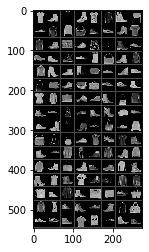

In [8]:
img, label = next(iter(reservedLoader))
imshow(torchvision.utils.make_grid(img))

In [9]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
print(device)

# device2 = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

cuda:3


# Decentralized model using reserved data

## Train a knowledge transfer model

In [10]:
def kaiming_init(m):
    if isinstance(m, (torch.nn.Linear)):
        torch.nn.init.sparse_(m.weight, sparsity=0.33)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (torch.nn.Conv2d)):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)

class Decenter(torch.nn.Module):

    def __init__(self, shape):
        super(Decenter, self).__init__()
        if len(shape) == 1:
            shape = shape[0]
            self.dim = 0
        elif len(shape) == 2:
            shape = shape[1]
            self.dim = 1
        self.translation = torch.nn.Sequential(
#             torch.nn.Tanh(),
            torch.nn.Linear(shape*3, shape)
        )

#         self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, source1, source2, target):
        x = torch.cat((source1, source2, target), self.dim)
#         x = torch.cat((torch.flatten(source), torch.flatten(target)), 0)
#         x = torch.add(torch.flatten(source).to("cpu"), torch.flatten(target).to("cpu"))
        res = self.translation(x)
#         res = res.reshape(target.shape)
        return res
    
    
class Interpolate(torch.nn.Module):
    def __init__(self, size, mode):
        super(Interpolate, self).__init__()
        self.interp = torch.nn.functional.interpolate
        self.size = size
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, size=self.size, mode=self.mode, align_corners=False)
        return x
    
class Reshape(torch.nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
    
class Decenter_pooled(torch.nn.Module):

    def __init__(self, shape):
        super(Decenter_pooled, self).__init__()
        self.shape = shape
        self.translation = torch.nn.Sequential(
#             torch.nn.BatchNorm2d(channels_out),
#             torch.nn.AdaptiveAvgPool2d(1),
            Interpolate(size=1, mode='bilinear'),
            Reshape(shape[0], shape[1]*2),
            torch.nn.Linear(shape[1]*2, shape[1]*shape[-1]*shape[-1]),
#             Reshape(shape[0], shape[1] ,1 ,1),
        )

#         self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, source, target):
        x = torch.cat((source, target), 1)
        res = self.translation(x)
        res = res.view(self.shape[0], self.shape[1], self.shape[2], self.shape[3])
        return res
    
    
class Decenter_conv(torch.nn.Module):

    def __init__(self, shape):
        super(Decenter_conv, self).__init__()
        self.shape = shape
        channels_in = shape[1]*3
        channels_out = shape[1]
        self.translation = torch.nn.Sequential(
            torch.nn.BatchNorm2d(channels_in),
            torch.nn.Conv2d(channels_in, channels_out, 3, stride=1, padding=1)
#             torch.nn.ConvTranspose2d(channels_in, channels_out, 3, stride=1, padding=1)
#             torch.nn.Linear(shape[0]*2, shape[0]*4),
#             torch.nn.Dropout(p=0.5),
#             torch.nn.Linear(shape[0]*2, shape[0]),
#             torch.nn.AdaptiveAvgPool2d((shape[-2],shape[-1])),
#             torch.nn.Conv2d(channels_out, channels_out, 3, stride=1, padding=1)

        )
        self.translation2 = torch.nn.Sequential(
            torch.nn.AdaptiveMaxPool2d((shape[-2],shape[-1])),
        )

#         self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, source1, source2, target):
        x = torch.cat((source1, source2, target), 1)
#         x = x.reshape(-1, x.shape[0])
#         x = torch.cat((torch.flatten(source), torch.flatten(target)), 0)
#         x = torch.add(torch.flatten(source).to("cpu"), torch.flatten(target).to("cpu"))
        res = self.translation(x)
#         res = res.reshape(self.shape)
        return res

In [16]:
grad_dict: dict = {}
def fc_hook(layer_name, grad_input, grad_output): 
    if layer_name not in grad_dict:
        grad_dict[layer_name] = {}
        grad_dict[layer_name]["grad_input"] = []
        grad_dict[layer_name]["grad_output"] = []
        grad_dict[layer_name]["labels"] = []
        
#     print(grad_input)
#     print(grad_output)
    grad_dict[layer_name]["grad_input"].append(grad_input[0].cpu().numpy())
    grad_dict[layer_name]["grad_output"].append(grad_output[0].cpu().numpy())
    
# def reserve_step(source, target):
    
reslist = []
matlst = []
fclst = []

options = {0: ['trainA', 'validA','reservedAB'], 
           1: ['trainB','validB','reservedBA'],
           2: ['trainC','validC','reservedCA','validC']}

def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
#     writer = SummaryWriter('runs/') 

    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = 0.0
    best_acc = 0.0
    dataset_sizes = {'trainA': len(dataloders['trainA'].sampler),
                     'trainB': len(dataloders['trainB'].sampler),
                     'trainC': len(dataloders['trainC'].sampler),
                     'reservedA': len(dataloders['reservedA'].sampler),
                     'reservedB': len(dataloders['reservedB'].sampler),
                     'reservedCA': len(dataloders['reservedCA'].sampler),
                     'reservedAB': len(dataloders['reservedAB'].sampler),
                     'reservedBA': len(dataloders['reservedBA'].sampler),
                     'validA': len(dataloders['validA'].sampler),
                     'validB': len(dataloders['validB'].sampler),
                     'validC': len(dataloders['validC'].sampler)}

    i = 0
    ivc = 0
    for epoch in range(num_epochs):
        for phase in ['trainA', 'validA','trainB','validB','trainC','validC','reservedCA','validC']:
#         choice = np.random.choice(range(3), replace=False)
#         for phase in options[choice]:
            if phase not in ['validA','validB','validC']:
                model[phase].train(True)
            else:
                model['trainA'].train(False)
                model['trainB'].train(False)
                model['trainC'].train(False)
            
            
            running_loss = 0.0
            running_corrects = 0                    
                    
            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer[phase].zero_grad()

                outputs = model[phase](inputs)
                _, preds = torch.max(outputs.data, 1)
                
                if phase in ['reservedCA','reservedAB','reservedBA']:
                    loss_a = criterion['trainC'](outputs, labels)
                    if phase == 'reservedCA':
                        outputs2 = model['trainA'](inputs)
                        outputs3 = model['trainB'](inputs)
                    elif phase == 'reservedAB':
                        outputs2 = model['trainC'](inputs)
                        outputs3 = model['trainB'](inputs)
                    elif phase == 'reservedBA':
                        outputs2 = model['trainC'](inputs)
                        outputs3 = model['trainA'](inputs)
    
                    sm = torch.nn.Softmax(dim=1)
                    outputs = sm(outputs)
                    outputs2 = sm(outputs2)
                    outputs3 = sm(outputs3)
                    loss_b = criterion[phase](outputs, outputs2)
                    loss_c = criterion[phase](outputs, outputs3)
                    loss = (loss_a + (loss_b + loss_c)/2)/2
                else:
                    loss = criterion[phase](outputs, labels)

                if phase not in ['validA','validB','validC']:
                    loss.backward()
                    optimizer[phase].step()
                                    
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            if phase in ['validA','validB','validC']:
                scheduler[phase].step(running_loss)
                
            if phase not in ['validA','validB','validC']:
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects.double() / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print('Epoch [{}/{}] phase: {} train loss: {:.4f} acc: {:.4f} ' 
                      'valid loss: {:.4f} acc: {:.4f}'.format(
                        epoch, num_epochs - 1,
                        phase,
                        train_epoch_loss, train_epoch_acc, 
                        valid_epoch_loss, valid_epoch_acc))
                print() 
                logger.info('Epoch [{}/{}] phase: {} train loss: {:.4f} acc: {:.4f} ' 
                      'valid loss: {:.4f} acc: {:.4f}'.format(
                        epoch, num_epochs - 1,
                        phase,
                        train_epoch_loss, train_epoch_acc, 
                        valid_epoch_loss, valid_epoch_acc))
                
                # Writing to tensorboard
                if phase == 'validC':
                    ivc += 1
                    if ivc == 2:
#                         writer.add_histogram('distribution centers/our_full_mesh', outputs, i)

#                         writer.add_scalar('train/loss_our_full_mesh', train_epoch_loss, epoch)
#                         writer.add_scalar('train/accuracy_our_full_mesh', train_epoch_acc, epoch)

#                         writer.add_scalar('valid/loss_our_full_mesh', valid_epoch_loss, epoch)
#                         writer.add_scalar('valid/accuracy_our_full_mesh', valid_epoch_acc, epoch)
                        reslist.append(valid_epoch_acc.item())
                        ivc = 0

                
            if phase in ['validA','validB','validC'] and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model[phase].state_dict()

            i+=1
    print('Best val Acc: {:4f}'.format(best_acc))
    logger.info('Best val Acc: {:4f}'.format(best_acc))

#     writer.close()
#     model.load_state_dict(best_model_wts)
    return model

In [17]:
resnetA = models.resnet50(pretrained=True)
resnetB = models.resnet50(pretrained=True)
resnetC = models.resnet50(pretrained=True)
# freeze all model parameters
# for param in resnet.parameters():
#     param.requires_grad = False

# new final layer with 10 classes
num_ftrsA = resnetA.fc.in_features
resnetA.fc = torch.nn.Linear(num_ftrsA, 10)
resnetA.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

num_ftrsB = resnetB.fc.in_features
resnetB.fc = torch.nn.Linear(num_ftrsB, 10)
resnetB.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

num_ftrsC = resnetC.fc.in_features
resnetC.fc = torch.nn.Linear(num_ftrsC, 10)
resnetC.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

def fc_backward_hook(module, grad_input, grad_output):  # module is Linear in this case. Ignored.
        fc_hook("fc", grad_input, grad_output)
resnetA.fc_hook_handle = resnetA.fc.register_backward_hook(fc_backward_hook)
resnetB.fc_hook_handle = resnetB.fc.register_backward_hook(fc_backward_hook)
resnetC.fc_hook_handle = resnetC.fc.register_backward_hook(fc_backward_hook)


def roc_auc_score_micro(y_pred_proba, y_true):
    y_pred_proba = y_pred_proba.detach().cpu()
    y_true = y_true.detach().cpu()
    return metrics.roc_auc_score(
        label_binarize(y_true, classes=list(range(y_pred_proba.shape[1]))).ravel(),
        y_pred_proba.flatten())


resnetA = resnetA.to(device)
resnetB = resnetB.to(device)
resnetC = resnetC.to(device)

criterionA = torch.nn.CrossEntropyLoss()
# criterionB = torch.nn.CrossEntropyLoss()
# criterionA = torch.nn.KLDivLoss()
criterionB = torch.nn.KLDivLoss(reduction = 'batchmean')
# criterionB = torch.nn.KLDivLoss(reduction = 'mean')
# criterionB = torch.nn.MSELoss()
optimizerA = torch.optim.SGD(resnetA.parameters(), lr=0.01, momentum=0.9)
optimizerB = torch.optim.SGD(resnetB.parameters(), lr=0.01, momentum=0.9)
optimizerC = torch.optim.SGD(resnetC.parameters(), lr=0.01, momentum=0.9)
# optimizerA = torch.optim.AdamW(resnetA.parameters(), lr=0.001, betas=(0.9, 0.999))
# optimizerB = torch.optim.AdamW(resnetB.parameters(), lr=0.001, betas=(0.9, 0.999))
# optimizerC = torch.optim.AdamW(resnetC.parameters(), lr=0.001, betas=(0.9, 0.999))

# exp_lr_schedulerA = lr_scheduler.StepLR(optimizerA, step_size=5, gamma=0.01)
# exp_lr_schedulerB = lr_scheduler.StepLR(optimizerB, step_size=5, gamma=0.01)
# exp_lr_schedulerC = lr_scheduler.StepLR(optimizerC, step_size=5, gamma=0.2)
exp_lr_schedulerA = lr_scheduler.ReduceLROnPlateau(optimizerA, 'min', factor=0.90, patience=500)
exp_lr_schedulerB = lr_scheduler.ReduceLROnPlateau(optimizerB, 'min', factor=0.90, patience=500)
exp_lr_schedulerC = lr_scheduler.ReduceLROnPlateau(optimizerC, 'min', factor=0.90, patience=500)


def hwout(Hin, padding, dilation, kernel_size, stride):
    return (Hin + 2 * padding - dilation * (kernel_size-1) - 1)/stride + 1

In [18]:
max_layer = 0
max_neurons = 0
for prm in resnetC.named_parameters():
    num_ftr = np.prod(prm[1].shape)
    if num_ftr > max_neurons:
         max_neurons = num_ftr
         max_layer = prm[1]

In [14]:
[x[0] for x in resnetC.named_parameters()]

['conv1.weight',
 'bn1.weight',
 'bn1.bias',
 'layer1.0.conv1.weight',
 'layer1.0.bn1.weight',
 'layer1.0.bn1.bias',
 'layer1.0.conv2.weight',
 'layer1.0.bn2.weight',
 'layer1.0.bn2.bias',
 'layer1.0.conv3.weight',
 'layer1.0.bn3.weight',
 'layer1.0.bn3.bias',
 'layer1.0.downsample.0.weight',
 'layer1.0.downsample.1.weight',
 'layer1.0.downsample.1.bias',
 'layer1.1.conv1.weight',
 'layer1.1.bn1.weight',
 'layer1.1.bn1.bias',
 'layer1.1.conv2.weight',
 'layer1.1.bn2.weight',
 'layer1.1.bn2.bias',
 'layer1.1.conv3.weight',
 'layer1.1.bn3.weight',
 'layer1.1.bn3.bias',
 'layer1.2.conv1.weight',
 'layer1.2.bn1.weight',
 'layer1.2.bn1.bias',
 'layer1.2.conv2.weight',
 'layer1.2.bn2.weight',
 'layer1.2.bn2.bias',
 'layer1.2.conv3.weight',
 'layer1.2.bn3.weight',
 'layer1.2.bn3.bias',
 'layer2.0.conv1.weight',
 'layer2.0.bn1.weight',
 'layer2.0.bn1.bias',
 'layer2.0.conv2.weight',
 'layer2.0.bn2.weight',
 'layer2.0.bn2.bias',
 'layer2.0.conv3.weight',
 'layer2.0.bn3.weight',
 'layer2.0.bn3.b

In [19]:
### Define phases 
dloaders = {'trainA':trainsetLoader1, 'trainB':reservedLoaderB, 'trainC':reservedLoader,
            'validA':testsetLoader, 'validB':testsetLoader, 'validC':testsetLoader,
            'reservedA':reservedLoader, 'reservedB':reservedLoader, 'reservedCA':reservedLoader, 'reservedAB':reservedLoader, 'reservedBA':reservedLoader}
model = {'trainA':resnetA, 'trainB':resnetB, 'trainC':resnetC,
         'validA':resnetA, 'validB':resnetB, 'validC':resnetC,
         'reservedA':resnetA, 'reservedB':resnetB, 'reservedCA':resnetC, 'reservedAB':resnetA, 'reservedBA':resnetB}
optimizer = {'trainA':optimizerA, 'trainB':optimizerB, 'trainC':optimizerC,
             'validA':optimizerA, 'validB':optimizerB, 'validC':optimizerC,
             'reservedA':optimizerA, 'reservedB':optimizerB, 'reservedCA':optimizerC, 'reservedAB':optimizerA, 'reservedBA':optimizerB}
criterion = {'trainA':criterionA, 'trainB':criterionA, 'trainC':criterionA,
             'validA':criterionA, 'validB':criterionA, 'validC':criterionA,
             'reservedA':criterionB, 'reservedB':criterionB, 'reservedCA':criterionB, 'reservedAB':criterionB, 'reservedBA':criterionB}
exp_lr_scheduler = {'trainA':exp_lr_schedulerA, 'trainB':exp_lr_schedulerB, 'trainC':exp_lr_schedulerC,
             'validA':exp_lr_schedulerA, 'validB':exp_lr_schedulerB, 'validC':exp_lr_schedulerC,
             'reservedA':exp_lr_schedulerA, 'reservedB':exp_lr_schedulerB, 'reservedCA':exp_lr_schedulerC, 'reservedAB':exp_lr_schedulerA, 'reservedBA':exp_lr_schedulerB}

In [20]:
logging.info("#### bn acti conv and fc - unlimited bn - adam learning rate 0.001 - scheduler 20 - opt adamw ####")

start_time = time.time()
model = train_model(dloaders, model, criterion, optimizer, exp_lr_scheduler, num_epochs=60)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch [0/59] phase: validA train loss: 0.0017 acc: 0.9227 valid loss: 0.0679 acc: 0.2762

Epoch [0/59] phase: validB train loss: 0.0037 acc: 0.8592 valid loss: 0.0086 acc: 0.6297

Epoch [0/59] phase: validC train loss: 0.0034 acc: 0.8693 valid loss: 0.0110 acc: 0.4922

Epoch [0/59] phase: validC train loss: -0.0022 acc: 0.9177 valid loss: 0.0108 acc: 0.5149

Epoch [1/59] phase: validA train loss: 0.0007 acc: 0.9711 valid loss: 0.0630 acc: 0.2862

Epoch [1/59] phase: validB train loss: 0.0021 acc: 0.9137 valid loss: 0.0083 acc: 0.6538

Epoch [1/59] phase: validC train loss: 0.0018 acc: 0.9242 valid loss: 0.0099 acc: 0.5903

Epoch [1/59] phase: validC train loss: -0.0025 acc: 0.9339 valid loss: 0.0083 acc: 0.6481

Epoch [2/59] phase: validA train loss: 0.0006 acc: 0.9729 valid loss: 0.0688 acc: 0.2901

Epoch [2/59] phase: validB train loss: 0.0018 acc: 0.9240 valid loss: 0.0071 acc: 0.6747

Epoch [2/59] phase: validC train loss: 0.0015 acc: 0.9362 valid loss: 0.0086 acc: 0.6211

Epoch [2

In [21]:
reslist

[0.5149,
 0.6481,
 0.5823,
 0.6138,
 0.6659,
 0.6735,
 0.6521,
 0.7073,
 0.7111000000000001,
 0.7522000000000001,
 0.6993,
 0.7127,
 0.77,
 0.7277,
 0.7578,
 0.7388,
 0.7555000000000001,
 0.7525000000000001,
 0.7519,
 0.7497,
 0.7549,
 0.8004,
 0.7745000000000001,
 0.7733,
 0.7758,
 0.7551,
 0.7812,
 0.777,
 0.7652,
 0.7708,
 0.7852,
 0.7691,
 0.7882,
 0.7724000000000001,
 0.7772,
 0.7659,
 0.7658,
 0.7839,
 0.7887000000000001,
 0.7911,
 0.7803,
 0.791,
 0.7923,
 0.7873,
 0.7855000000000001,
 0.7762,
 0.7822,
 0.7641,
 0.769,
 0.7835000000000001,
 0.7582,
 0.777,
 0.7752,
 0.7755000000000001,
 0.7814,
 0.7702,
 0.7744000000000001,
 0.7867000000000001,
 0.7857000000000001,
 0.7682]

## Testing ground

In [22]:
confusion_matrix = torch.zeros(10, 10)
for inputs, labels in dloaders['validC']:
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    outputs = model['validC'](inputs)
    _, preds = torch.max(outputs.data, 1)
    
    for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
print(confusion_matrix)

tensor([[443.,   0.,   4.,   6.,   2.,   2., 512.,   0.,  29.,   2.],
        [  1., 940.,   0.,   8.,   3.,   0.,  38.,   0.,   4.,   6.],
        [  2.,   0., 264.,   3., 122.,   0., 592.,   0.,  17.,   0.],
        [ 10.,   7.,   6., 686.,  19.,   0., 243.,   0.,  16.,  13.],
        [  1.,   0.,  12.,  17., 611.,   0., 344.,   0.,  14.,   1.],
        [  0.,   0.,   1.,   0.,   0., 913.,   2.,  35.,  11.,  38.],
        [ 12.,   0.,   6.,   8.,  20.,   1., 933.,   0.,  18.,   2.],
        [  0.,   0.,   0.,   0.,   0.,  11.,   0., 918.,   3.,  68.],
        [  0.,   0.,   0.,   1.,   0.,   1.,   7.,   0., 991.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   1.,   0.,  15.,   1., 983.]])
